###Import libraries 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import ceil
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()

###Set hyper parameters
#### ------ Design choice ------
 [ (CONV - RELU)*N --> POOL ]*M --> (FC - RELU)*K --> SOFTMAX \
As per this desgin choice: \
Total number of convoulation layers = N*M \
Total feature maps = User defined list. But, length of that list = N*M \
Total pool layers = M \
Total FC layers = K \

In [ ]:
N = 1 
M = 1
K = 1
n_feature_maps = [64] # length of this list must be = N*M
n_fc_neurons = [128] # length of this list must be = K
n_classes = 10
conv_kernel_size = 5
conv_stride = 2
pool_size = 2
pool_stride = 2
n_batch = 128
n_epoch = 20
regularizer_rate = 0.005
learning_rate = 0.001

if len(n_feature_maps) != N*M:
	print('Number of feature maps need to be corrected')
	sys.exit(1)

if len(n_fc_neurons) != K:
	print('Number of fully connected neurons need to be corrected')
	sys.exit(1)

###Load data
####Following funtion loads MNIST dataset hosted in Yann LeCun website "http://yann.lecun.com/exdb/mnist/" 

Loading MNIST dataset
Data is successfully loaded


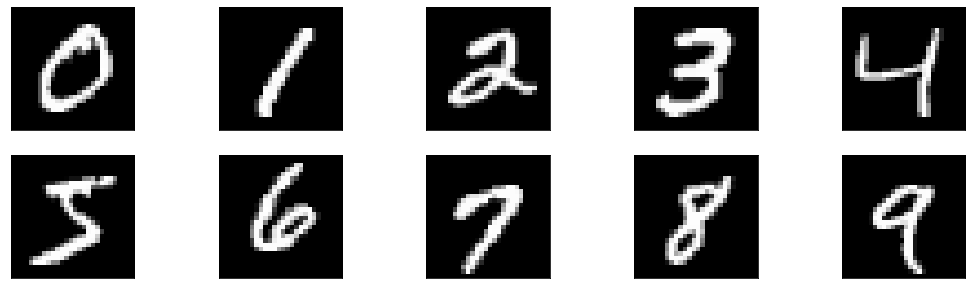

In [ ]:
print('Loading MNIST dataset')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('Data is successfully loaded')

fig_size = [18, 5]
label_fontsize = 20
fig = plt.figure(figsize=fig_size)
for img_sample in np.arange(10):  
  img_index = np.where(y_train==img_sample)[0][0]
  img = x_train[img_index]
  ax = plt.subplot(2, 5, img_sample+1)
  ax.imshow(img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Convert y labels (both test and train) to one-hot vectors

In [ ]:
print('Converting y labels of test and train data to one-hot vectors')
y_train_one_hot = tf.one_hot(y_train, n_classes)
y_train_one_hot = y_train_one_hot.eval(session=tf.compat.v1.Session())
y_test_one_hot = tf.one_hot(y_test, n_classes)
y_test_one_hot = y_test_one_hot.eval(session=tf.compat.v1.Session())

Converting y labels of test and train data to one-hot vectors


###Reshape input images to 4D vectors

In [ ]:
inp_x = x_train.shape[1]
inp_y = x_train.shape[2]
if len(x_train.shape) < 4:
	print('Reshaping train and test input data to 4D vectors')
	x_train_reshape = x_train[:,:,:,np.newaxis]
	x_test_reshape = x_test[:,:,:,np.newaxis]
	n_channel = 1	
else:
	print('Input is already a 4D vector')
	n_channel = x_train.shape[-1]

Reshaping train and test input data to 4D vectors


###Brief the network architecture

In [ ]:
def get_feature_map_size():
	# This function is made considering that we use padding = 'SAME' for convolution and 'VALID' for pooling
	map_size = []
	conv_count = 0
	for layer_ in range((N+1)*M):
		if layer_ == 0:
			feature_map_size = ceil(inp_x/conv_stride)
			conv_count += 1		
		elif conv_count < N:				
			feature_map_size = ceil(feature_map_size/conv_stride)	
			conv_count += 1
		else:
			feature_map_size = ceil(((feature_map_size - pool_size + 1)/pool_stride))	
			conv_count = 0
		map_size.append(feature_map_size)
	return map_size

		
n_data_split = ceil(x_train.shape[0]/n_batch)
tot_layers = (N*M) + K + 1
print('Total layers = {}'.format(tot_layers))
size_of_feature_maps_before_first_fc_layer = get_feature_map_size()


print('')
print('-----------Network architecture design is as follows:-------------')
print('[(CONV-->RELU)*{} --> POOL]*{} --> (FC-RELU)*{} --> SOFTMAX'.format(N, M, K))
print('Input shape = {}x{}x{}'.format(inp_x, inp_y, n_channel))
print('Convolution kernel size = {}x{}'.format(conv_kernel_size, conv_kernel_size))
print('Convolution stride = {}x{}'.format(conv_stride, conv_stride))
print('Number of convolution feature maps = {}'.format(n_feature_maps))
print('Maxpool size = {}x{}'.format(pool_size, pool_size))
print('Maxpool stride = {}x{}'.format(pool_stride, pool_stride))
print('Size of feature maps are: {}'.format(size_of_feature_maps_before_first_fc_layer))
print('Number of neurons in FC hidden layer = {}'.format(n_fc_neurons))
print('-------------------------------------------------------------------')
print('')
print('-----------Network training hyper-parameters are as follows:-----------')
print('Number of training epochs = {}'.format(n_epoch))
print('Number of training data per batch = {}'.format(n_batch))
print('Learning rate = {}'.format(learning_rate))
print('Regularization rate = {}'.format(regularizer_rate))
print('-------------------------------------------------------------------')

Total layers = 3

-----------Network architecture design is as follows:-------------
[(CONV-->RELU)*1 --> POOL]*1 --> (FC-RELU)*1 --> SOFTMAX
Input shape = 28x28x1
Convolution kernel size = 5x5
Convolution stride = 2x2
Number of convolution feature maps = [64]
Maxpool size = 2x2
Maxpool stride = 2x2
Size of feature maps are: [14, 7]
Number of neurons in FC hidden layer = [128]
-------------------------------------------------------------------

-----------Network training hyper-parameters are as follows:-----------
Number of training epochs = 20
Number of training data per batch = 128
Learning rate = 0.001
Regularization rate = 0.005
-------------------------------------------------------------------


###Initialise place holders for data and label

In [ ]:
x = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, inp_x, inp_y, n_channel])
y = tf.compat.v1.placeholder(dtype=tf.float32)

###Initalize variables for weight matrix

In [ ]:
first_fc_key_in_layer_dict = N*M
def initialise_layer_dict():
  layer_dict = {}
  fc_layer_count = 0  
  for layer in range(tot_layers):
    if layer <= (N*M)-1:
      if layer == 0:
        depth = n_channel
      else:
        depth = n_feature_maps[layer-1]
      layer_dict[layer] = {'weights':tf.Variable(tf.random.normal([conv_kernel_size, conv_kernel_size, depth, n_feature_maps[layer]], stddev=1/tf.sqrt(float(conv_kernel_size*conv_kernel_size))), dtype=tf.float32, name='conv_weights_{}'.format(layer)), 
                'biases':tf.Variable(tf.random.normal([n_feature_maps[layer]]), dtype=tf.float32, name='conv_biases_{}'.format(layer))}
    else:		
      if layer == (N*M):		
        fc_inp_feature_number = size_of_feature_maps_before_first_fc_layer[-1]**2*n_feature_maps[-1]
      else:
        fc_inp_feature_number = n_fc_neurons[fc_layer_count-1]
      if layer == tot_layers-1:
        fc_out_feature_number = n_classes
      else:
        fc_out_feature_number = n_fc_neurons[fc_layer_count]
      fc_layer_count += 1
      layer_dict[layer] = {'weights':tf.Variable(tf.random.normal([fc_inp_feature_number, fc_out_feature_number], stddev=1/tf.sqrt(float(fc_inp_feature_number))), dtype=tf.float32, name='fc_weights_{}'.format(layer)), 
                  'biases':tf.Variable(tf.random.normal([fc_out_feature_number]), dtype=tf.float32, name='fc_biases_{}'.format(layer))}
  return layer_dict

layer_dict = initialise_layer_dict()


###Functions for convolution and maxpooling

In [ ]:
def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1, conv_stride, conv_stride, 1], padding='SAME')

def maxpool2d(x):
	return tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_stride, pool_stride, 1], padding='VALID')

###Model the convolutional neural network

In [ ]:
def conv_neural_network(data):
	layer_resp_dict = {}
	conv_count = 0
	fc_count = 0
	for item in layer_dict.items():
		layer = item[0]
		layer_now = layer_dict[layer]
		layer_weight = layer_now['weights']
		layer_bias = layer_now['biases']
		if layer < first_fc_key_in_layer_dict: 
			if layer == 0:
				 layer_resp_activation = data
			layer_resp = tf.add(conv2d(layer_resp_activation, layer_weight), layer_bias)
			layer_resp_activation = tf.nn.relu(layer_resp)
			conv_count += 1
			if conv_count == N:
				layer_resp_activation = maxpool2d(layer_resp_activation)
				conv_count = 0
		else:
			fc_count += 1
			if layer == first_fc_key_in_layer_dict:
				layer_resp_activation = tf.reshape(layer_resp_activation, [-1, size_of_feature_maps_before_first_fc_layer[-1]**2*n_feature_maps[-1]])
			layer_resp = tf.add(tf.matmul(layer_resp_activation, layer_weight), layer_bias)
			if fc_count <= K:
				layer_resp_activation = tf.nn.relu(layer_resp)
			else:
				layer_resp_activation = tf.nn.softmax(layer_resp)
		layer_resp_dict[layer] = layer_resp_activation
	return layer_resp_dict

###Train the neural network

In [ ]:
def train_neural_network(x):
    start_time = time.time()
    layer_resp_dict = conv_neural_network(x)	
    prediction = layer_resp_dict[tot_layers-1]
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    weight_regularization = 0
    weight_list = []
    bias_list = []
    for item in layer_dict.items():
      layer = item[0]
      layer_now = layer_dict[layer]
      layer_weight = layer_now['weights']
      layer_bias = layer_now['biases']
      weight_regularization = weight_regularization + regularizer_rate*tf.nn.l2_loss(layer_weight)
      weight_list.append(layer_weight)
      bias_list.append(layer_bias)
    optimize_var_list = weight_list + bias_list
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)) + weight_regularization
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, var_list=optimize_var_list)
    gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
      sess.run(tf.compat.v1.global_variables_initializer())
      data_index_arr = np.arange(x_train.shape[0])
      epch_cost_list = []
      epch_accuracy_list = []
      for epoch in range(n_epoch):
        np.random.shuffle(data_index_arr)
        cost_ = 0
        for index_split in np.array_split(data_index_arr, n_data_split):
          x_train_batch = x_train_reshape[index_split]
          y_train_batch = y_train_one_hot[index_split]
          sess.run(optimizer, feed_dict={x:x_train_batch, y:y_train_batch})
          cost_ = cost_ + sess.run(cost, feed_dict={x:x_train_batch, y:y_train_batch})
        epch_cost_list.append(cost_)
        epch_accuracy = sess.run(accuracy, feed_dict={x:x_train_reshape, y:y_train_one_hot})
        epch_accuracy_list.append(epch_accuracy)
        print('Epoch = {}, cost = {}, accuracy = {}'.format(epoch, cost_, epch_accuracy))

      print('Accuracy on test dataset = {}'.format(sess.run(accuracy, feed_dict={x:x_test_reshape, y:y_test_one_hot})))

      print('Plotting cost function vs training epoch')
      fig_size = [10, 5]
      label_fontsize = 18
      fig = plt.figure(figsize=fig_size)
      ax = plt.subplot(131)
      epoch_arr = np.arange(n_epoch)
      ax.plot(epoch_arr, epch_cost_list, linewidth=3)
      ax.set_xlabel('Epoch number', fontsize=label_fontsize)
      ax.set_ylabel('Cost function', fontsize=label_fontsize)
      ax.set_title('Cost function vs training epoch', fontsize=label_fontsize)
      ax.set_xticks(epoch_arr)
      ax.spines['right'].set_visible(False)
      ax.spines['top'].set_visible(False)  

      print('Plotting accuracy vs training epoch')
      ax = plt.subplot(133)
      epoch_arr = np.arange(n_epoch)
      ax.plot(epoch_arr, epch_accuracy_list, linewidth=3)
      ax.set_xlabel('Epoch number', fontsize=label_fontsize)
      ax.set_ylabel('Accuracy', fontsize=label_fontsize)
      ax.set_title('Accuracy vs training epoch', fontsize=label_fontsize)
      ax.set_xticks(epoch_arr)
      ax.spines['right'].set_visible(False)
      ax.spines['top'].set_visible(False)
      plt.show()

      print('Saving checkpoints...')
      variable_list = []
      for item in layer_dict.items():
        layer = item[0]
        layer_now = layer_dict[layer]
        globals()[f"weight_{layer}"] = layer_now['weights']
        globals()[f"bias_{layer}"] = layer_now['biases']
        variable_list.append(globals()[f"weight_{layer}"])
        variable_list.append(globals()[f"bias_{layer}"])
      saver = tf.compat.v1.train.Saver(variable_list)
      save_path = saver.save(sess, "./saved_variables_conv_net_mnist.ckpt")
      print('Checkpoints are saved')


      end_time = time.time()
      tot_time = round((end_time-start_time)/60, 2)
      print('Network training is completed in {} minutes'.format(tot_time))

###Run the network

Epoch = 0, cost = 1168.5853345394135, accuracy = 0.09929999709129333
Epoch = 1, cost = 1113.8642764091492, accuracy = 0.09929999709129333
Epoch = 2, cost = 812.1040617227554, accuracy = 0.9699500203132629
Epoch = 3, cost = 711.2925463914871, accuracy = 0.9719499945640564
Epoch = 4, cost = 707.1916823387146, accuracy = 0.9796500205993652
Epoch = 5, cost = 705.5003750324249, accuracy = 0.9818833470344543
Epoch = 6, cost = 704.1092803478241, accuracy = 0.9818166494369507
Epoch = 7, cost = 703.7609935998917, accuracy = 0.9821000099182129
Epoch = 8, cost = 703.1436502933502, accuracy = 0.9829833507537842
Epoch = 9, cost = 703.1120928525925, accuracy = 0.9850833415985107
Epoch = 10, cost = 702.651863694191, accuracy = 0.9838666915893555
Epoch = 11, cost = 702.4777241945267, accuracy = 0.9845166802406311
Epoch = 12, cost = 702.2782491445541, accuracy = 0.9850500226020813
Epoch = 13, cost = 702.2300251722336, accuracy = 0.9823333621025085
Epoch = 14, cost = 702.1039564609528, accuracy = 0.9858

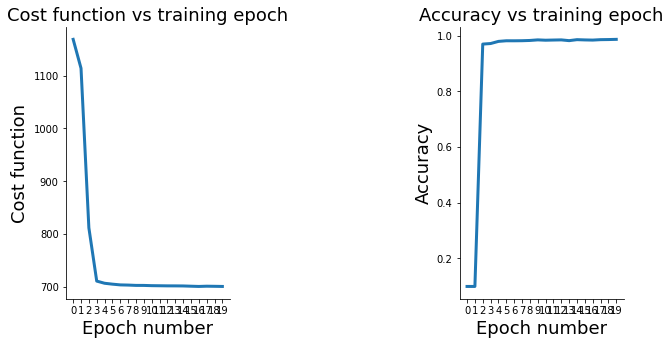

Saving checkpoints...
Checkpoints are saved
Network training is completed in 0.67 minutes


In [ ]:
train_neural_network(x)


###Prediction using the trained network 
####(a) Set the prediction function and load the saved weights

In [ ]:
variable_list = []
for item in layer_dict.items():
  layer = item[0]
  layer_now = layer_dict[layer]
  globals()[f"weight_{layer}"] = layer_now['weights']
  globals()[f"bias_{layer}"] = layer_now['biases']
  variable_list.append(globals()[f"weight_{layer}"])
  variable_list.append(globals()[f"bias_{layer}"])

saver = tf.compat.v1.train.Saver(variable_list)
def classify(image):
  if len(image.shape) == 2:
    image_ = image[tf.newaxis, ..., tf.newaxis]
  elif len(image.shape) == 3:
    image_ = image[tf.newaxis, ...]

  layer_resp_dict = conv_neural_network(x)
  prediction = layer_resp_dict[tot_layers-1]

  with tf.compat.v1.Session() as sess:
    saver.restore(sess, "./saved_variables_conv_net_mnist.ckpt")
    # layer_dict = {}
    layer_dict = initialise_layer_dict()
    for item in layer_dict.items():
      layer = item[0]
      layer_dict[layer] = {'weights':globals()[f"weight_{layer}"], 'biases':globals()[f"bias_{layer}"]}
    
    prediction_ = sess.run(prediction, feed_dict={x:image_})
    prediction_ = prediction_[0]
    return prediction_ 



###Prediction using the trained network 
####(b) Input a test image to the network

INFO:tensorflow:Restoring parameters from ./saved_variables_conv_net_mnist.ckpt


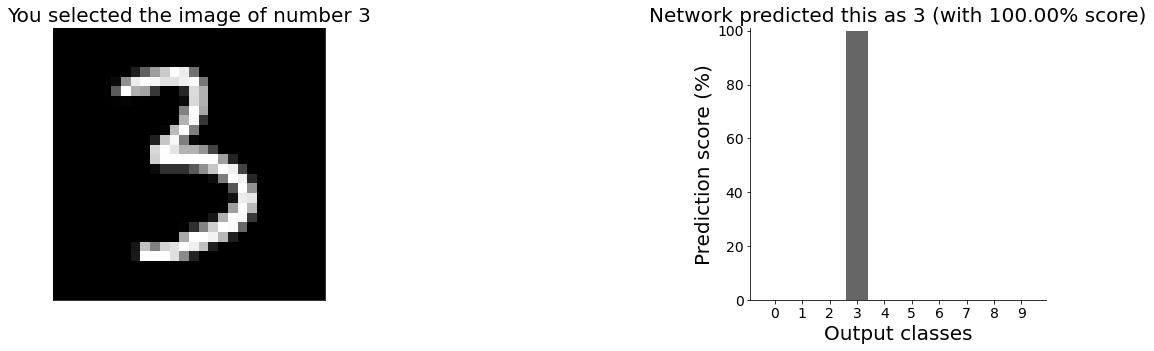

In [ ]:
# There are a total of 10,000 test images. Select any one of them below ranging from 0-9999 
# (For example, give test_image_index = 0, for inputing the first test image)
test_image_index = 3131

# Get the test image
input_class = y_test[test_image_index]
input_image = x_test[test_image_index]
prediction_out = classify(x_test[test_image_index])*100
predicted_max_score = round(prediction_out.max(),2)

# Plot input image
fig_size = [18, 5]
label_fontsize = 20
fig = plt.figure(figsize=fig_size)
ax = plt.subplot(131)
ax.imshow(input_image, cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('You selected the image of number {}'.format(input_class), fontsize=label_fontsize)

# Plot network output
ax = plt.subplot(133)
class_arr = np.arange(n_classes)
ax.bar(class_arr, prediction_out, linewidth=3, color=[0.4,0.4,0.4])
ax.set_xlabel('Output classes', fontsize=label_fontsize)
ax.set_ylabel('Prediction score (%)', fontsize=label_fontsize)
ax.set_title('Network predicted this as {0} (with {1:.2f}% score)'.format(np.argmax(prediction_out), predicted_max_score), fontsize=label_fontsize)
ax.set_xticks(class_arr)
ax.set_ylim(0,101)
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show() 

###Feature vector visualization using t-SNE
####(a) Computing t-SNE embedding vectors

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

layer_resp_dict = conv_neural_network(x)
feature_vector_last_hidden_layer = layer_resp_dict[tot_layers-2]

with tf.compat.v1.Session() as sess:
  start_time = time.time()
  saver.restore(sess, "./saved_variables_conv_net_mnist.ckpt")
  # layer_dict = {}
  layer_dict = initialise_layer_dict()
  for item in layer_dict.items():
    layer = item[0]
    layer_dict[layer] = {'weights':globals()[f"weight_{layer}"], 'biases':globals()[f"bias_{layer}"]}
  
  feature_vector_last_hidden_layer_ = sess.run(feature_vector_last_hidden_layer, feed_dict={x:x_test_reshape})
  tsne_results = tsne.fit_transform(feature_vector_last_hidden_layer_)
  end_time = time.time()
  tot_time = round((end_time-start_time)/60, 2)
  print('t-SNE is completed in {} min'.format(tot_time))


INFO:tensorflow:Restoring parameters from ./saved_variables_conv_net_mnist.ckpt
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.132s...
[t-SNE] Computed neighbors for 10000 samples in 6.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 8.327393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.78710

###Feature vector visualization using t-SNE
####(b) Plotting t-SNE embedding vectors

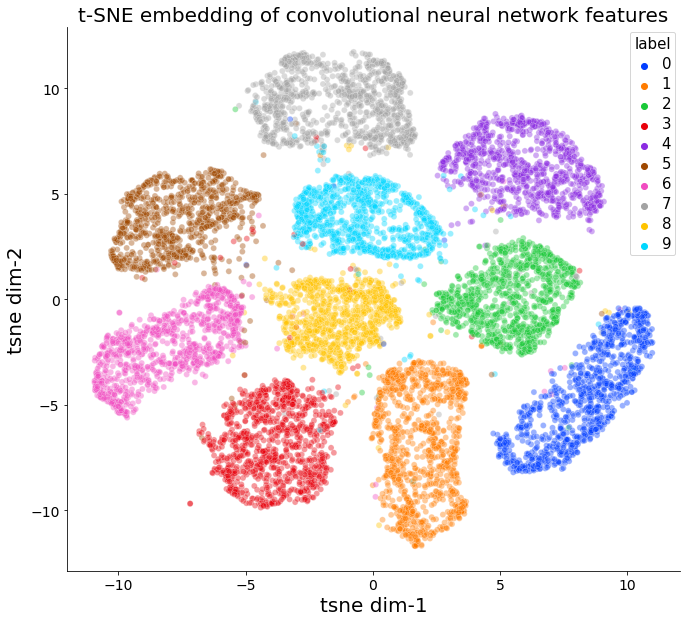

In [ ]:
label_fontsize = 20  
df_subset = pd.DataFrame()
df_subset['tsne dim-1'] = tsne_results[:,0]
df_subset['tsne dim-2'] = tsne_results[:,1]
df_subset['label'] = y_test

plt.figure(figsize=(11,10))
ax = plt.subplot(111)
ax.set_title('t-SNE embedding of convolutional neural network features', fontsize=label_fontsize)
sns.scatterplot(
    x=df_subset.columns[0], y=df_subset.columns[1],
    hue=df_subset.columns[2],
    palette=sns.color_palette(palette="bright", n_colors=10),
    data=df_subset,
    legend="full",
    alpha=0.4
)
ax.set_xlabel(df_subset.columns[0], fontsize=label_fontsize)
ax.set_ylabel(df_subset.columns[1], fontsize=label_fontsize)
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.show()